<h1 align=><font color='green'> Training an AI Agent with RAG</font></h1>

<nav>
  <a href="#langchain-and-langgraph">LangChain and LangGraph</a> |
  <a href="#ai-agents">AI Agents</a> |
  <a href="#retrieval-augmented-generation-rag">RAG</a> |
  <a href="#improving-agent-with-rag">Hands-on</a>
</nav>


### **Presenters**  
- Sourabh Zanwar | [LinkedIn](https://www.linkedin.com/in/sourabhznwr/)  
- Jose Arturo Garcia | [LinkedIn](https://www.linkedin.com/in/josegarcia93/)

### **Workshop Goals**  
- 🏗️ **Understand LangChain and LangGraph**  
- 🚀 **Build and deploy a working AI Agent**  
- 🧩 **Build and deploy a working AI Agent with RAG**  
- 🛠️ **Hands-on experience with RAG**  
- 🎉 **Have a great time doing it!**

<div class="alert alert-block alert-danger">  
<b>IMPORTANT:</b> We need the groq key to run the workshop. Please, add it to the `data/helper_functions.py` file.
</div>

<div class="alert alert-block alert-warning">  
<b>Reminder:</b> Let's run eveything in Colab  
</div>

<div class="alert alert-block alert-info">
<b>Please:</b> Always ask questions or raise your hand!
</div>

---

## ⚙️ Setting everything up

⚠️ First things first, lets create a groq key: [Groq Console](https://console.groq.com)

We’ll need a few libraries and some files to make our workshop run **smoothly**.  
First, we’ll install (or update) the required packages. Then, we’ll unzip our data into the correct folder so everything’s ready for action.

⚠️ Make sure your ZIP file is in the right place before you run the extraction code


In [ ]:
!pip install --upgrade --quiet langchain_community langchain_core langchain_openai langgraph pypdf langchain_groq fastembed chromadb

In [ ]:
import shutil
# Path to the zip file
zip_path = "data.zip"
# Destination folder
extract_to = "./data"
# Unpack the archive
shutil.unpack_archive(zip_path, extract_to)

⚠️ Remember: We need the groq key before runing next cell. Please, add it to the `data/helper_functions.py` file.

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from data.helper_functions import groq_key, create_tool_node_with_fallback, _print_event, handle_tool_error, generate_alphanumeric_code

In [ ]:
groq_key

In [ ]:
import os
os.environ["GROQ_API_KEY"] = groq_key

🥳 We are ready to start

## 🏁 Basics

<h2 id="langchain-and-langgraph">🧩 LangChain and LangGraph</h2>

### [LangChain Introduction](https://python.langchain.com/docs/introduction/)

LangChain implements a standard interface for large language models and related technologies, such as embedding models and vector stores, and integrates with hundreds of providers.

---


```python

    from langchain.chat_models import init_chat_model
    # 1️⃣ Initialize the model
    model = init_chat_model("llama3-8b-8192", model_provider="groq")

    # 2️⃣ Invoke the model with a test prompt
    model.invoke("Hello, world!")
```


### [LangGraph Introduction](https://langchain-ai.github.io/langgraph/)

Orchestration framework for combining LangChain components into production-ready applications with persistence, streaming, and other key features.


```python
    from typing import Annotated
    from typing_extensions import TypedDict
    from langgraph.graph import StateGraph, START, END
    from langgraph.graph.message import add_messages
    from langchain_anthropic import ChatAnthropic

    # 🧠 Initialize a language model from Anthropic
    llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")

    # 📝 Define the shape of our application state
    class State(TypedDict):
        messages: Annotated[list, add_messages]

    # 🤖 A simple chatbot function that calls the LLM with our messages
    def chatbot(state: State):
        return {"messages": [llm.invoke(state["messages"])]}

    # 🔗 Build a graph with a start node, chatbot node, and an end node
    graph_builder = StateGraph(State)
    graph_builder.add_node("chatbot", chatbot)
    graph_builder.add_edge(START, "chatbot")
    graph_builder.add_edge("chatbot", END)
```

## AI Agents

AI Agents combine **user input**, **LLMs**, and **tools** (like databases, APIs, or even custom scripts) to generate context-aware, actionable responses.

The diagram below shows the typical flow:


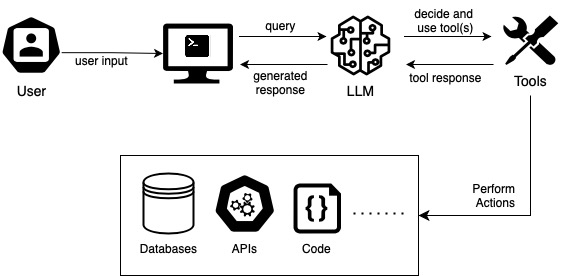


> **How It Works**  
> 1. **User Input**: The user provides a query or message.
> 2. **LLM Reasoning**: The AI model decides how to respond—directly or by invoking a tool.
> 3. **Tool Use**: If needed, the agent calls external resources (DBs, APIs, code, etc.).
> 4. **Actions & Final Response**: After gathering all necessary info, the agent returns an answer or performs an action.


### 🛠️ Defining Our Agent’s State

Below, we set up the data structures that track our conversation’s context. This includes a typed dictionary for storing messages.


In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages

# A typed dictionary to keep track of our messages.
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

This class defines an **AI assistant** that wraps a `Runnable` object. It continuously checks the response from the AI model, and if the response is empty or incomplete, it re-prompts the model for a valid output. This ensures you don’t end up with awkwardly empty responses.

> **Key Points**  
> - **Initialization**: Binds a `Runnable` to the Assistant.
>
> - **Call Behavior**: Invokes the `Runnable` with the current `state`.
> - **Validation Loop**: If the response is empty, the Assistant keeps asking for a “real” output until it gets one.
> - **Return**: Provides the final response in a dictionary.


In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig


class Assistant:
    def __init__(self, runnable: Runnable):
        """
        Initialize the Assistant with a Runnable object.

        :param runnable: A Runnable instance that handles the logic for generating responses.
        """
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        """
        Invoke the Assistant on the given state and configuration.

        Steps:
        1. Retrieve any additional configuration from 'configurable'.
        2. Invoke the Runnable (LLM or chain) with the current 'state'.
        3. If the response is empty, prompt again until we get a valid response.
        4. Return the final result wrapped in a dictionary.

        :param state: The current conversation state (messages, context, etc.).
        :param config: Configuration object that can tweak or modify how the run is executed.
        :return: A dictionary containing the final messages from the LLM.
        """
        while True:

            # Retrieve any extra configuration we might need
            configuration = config.get("configurable", {})

            # Invoke the LLM with the current state
            result = self.runnable.invoke(state)

            # Check if the LLM response is empty or invalid
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                # Add a user prompt to ask for a more complete output
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                # If we have a valid response, exit the loop
                break

        # Return the final messages in a dictionary
        return {"messages": result}

🛠️ Tools: Traffic & Weather

Here we define two tools using the `@tool` decorator from **langchain_core.tools**

-`get_traffic_conditions`

-`get_weather_conditions`

Each tool is a simple function that can be called by an AI agent to fetch information about a city’s current status.

> **How These Tools Work**  
> 1. **`get_traffic_conditions`**: Returns traffic levels (e.g., "normal," "very busy").
>   
> 2. **`get_weather_conditions`**: Returns a brief weather description (e.g., "5C, rainy").
>
> **Why This Matters**  
> - **Modular Design**: Each tool focuses on a single piece of data (traffic or weather).
>
> - **Agent Integration**: The agent can call these tools when it needs real-time info for a conversation.
> - **Config Flexibility**: The `config` parameter (`RunnableConfig`) allows you to pass in extra runtime settings if needed.


In [ ]:

from langchain_core.tools import tool

@tool
def get_traffic_conditions(config: RunnableConfig, city):
    """
    Get traffic conditions for a given city.
    """
    traffic_conditions = {
        'berlin': 'normal',
        'munich': 'very busy',
        'frankfurt': 'very busy'
    }
    return traffic_conditions[city.lower()]

@tool
def get_weather_conditions(config: RunnableConfig, city):
    """
    Get weather conditions for a given city.
    """
    weather_conditions = {
        'berlin': '5C, rainy',
        'munich': '2C, windy',
        'frankfurt': '-1C, snowy'
    }
    return weather_conditions[city.lower()]

🤝 Putting It All Together: The Assistant Runnable

Now we’ll instantiate a **ChatGroq** model, define a **prompt template**, and bind our traffic and weather tools to the LLM. This final step gives us a single pipeline (or “runnable”) that can handle user queries, parse them, and call the right tool for traffic or weather data as needed.

> **Key Steps**  
> 1. **Instantiate the Model**: We create a `ChatGroq` instance with a specific model name.
>   
> 2. **Build the Prompt Template**: A system prompt instructs the assistant to provide traffic and weather info using our tools. A “placeholder” slot (`"{messages}"`) captures user input.
> 3. **Bind Tools**: We provide the list of tools (traffic and weather) to the LLM.
> 4. **Pipe (`|`) the Prompt to the LLM**: This syntax creates an `assistant_runnable` that automatically uses the prompt template and tools whenever invoked.


In [ ]:
from langchain_groq import ChatGroq

# 1️⃣ Instantiate a ChatGroq model
llm = ChatGroq(model="llama-3.3-70b-versatile")

# 2️⃣ Define the primary prompt template
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant who provides traffic and weather information"
            "Use the provided tools to get the traffic and weather conditions for a city."
        ),
        ("placeholder", "{messages}"),
    ]
)

# 3️⃣ List the tools our assistant can use
tools = [
    get_traffic_conditions,
    get_weather_conditions
]

# 4️⃣ Pipe the prompt into the LLM and bind the tools, creating a single runnable
assistant_runnable = primary_assistant_prompt | llm.bind_tools(tools)

🌐 Building the Conversation Graph

In this section, we use **LangGraph** to orchestrate our AI assistant and tools into a cohesive flow. Here’s how it all comes together:

1. **Nodes**  
   - **Assistant**: The node that handles user messages and calls the AI model.  
   - **Tools**: A fallback node that routes requests to the appropriate tool when needed (traffic, weather, etc.).

2. **Edges**  
   - We define the path of execution: start with the assistant, check if we need tools, then loop back to the assistant.  
   - **Conditional Edges** let us decide if a tool is needed based on the AI’s output.

3. **Memory & Compilation**  
   - **MemorySaver**: Persists the conversation state across node executions.  
   - **Compile**: Finalizes the graph so it’s ready to handle incoming requests.

Use this graph to process user queries seamlessly—when a user asks for traffic or weather, the flow automatically branches to the right tool, then returns to the assistant for further dialogue.


In [ ]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition


# 1️⃣ Create a new StateGraph with our custom State type
builder = StateGraph(State)


# 2️⃣ Define nodes (the actual "workers" in the graph)
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(tools))

# 3️⃣ Define edges (the "roads" between nodes)
#    - Start goes to the assistant
#    - The assistant might conditionally go to tools
#    - Tools always go back to the assistant
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

# 4️⃣ Create a memory checkpointer to store conversation state across executions (graph persist)
# this is a complete memory for the entire graph.
memory = MemorySaver()

# 5️⃣ Compile the graph so it's ready to run
graph = builder.compile(checkpointer=memory)

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

🎙️ Running the Conversation

Now that we’ve defined our **graph** and tools, let’s put everything into action! We’ll:

1. Generate a **unique thread ID** to track our conversation state (using `uuid`).
2. Create a **configuration dictionary** that includes the thread ID for checkpointing.
3. Ask a series of **questions** about traffic and weather.
4. Use the graph’s **stream** method to process each question in real time and print out the events.

> **Key Details**  
> - **`thread_id`**: Helps our memory checkpoint keep each conversation separate.
>   
> - **`stream_mode="values"`**: Ensures we receive intermediate outputs from the graph as they occur.  
> - **`_print_event`**: A helper function (presumably defined elsewhere) that prints out each event in a user-friendly way.


In [ ]:
import uuid

# 1️⃣ Generate a unique thread ID for this conversation
thread_id = str(uuid.uuid4())

# 2️⃣ Build a configuration dictionary that includes the thread ID for checkpointing
config = {
    "configurable": {
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

# 3️⃣ Define a list of user questions to feed into the graph
questions = [
    "Can you tell me the traffic conditions in Berlin?",
    "I want to travel from munich to frankfurt, do I need an umbrella?",
]

In [ ]:
# Keep track of printed events to avoid duplicates
_printed = set()
for question in questions:

    # Invoke the graph with the user's question, passing the config
    events = graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )

    # Print each event using our custom _print_event function
    for event in events:
        _print_event(event, _printed)

## 🔎 Retrieval-Augmented Generation (RAG)

**Retrieval-Augmented Generation (RAG)** is a technique that enhances Large Language Models (LLMs) by **pulling relevant information** from external knowledge sources.

Rather than relying solely on the model’s internal parameters, RAG helps the LLM “look up” facts from databases, documents, or APIs.

This process leads to more **accurate**, **up-to-date**, and **context-rich** responses.

Lets see todays example


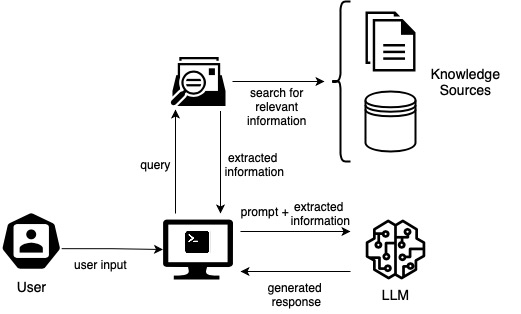

> **Key Steps in RAG**  
> 1. **User Input**: The user asks a question.  
> 2. **Retrieve**: The system searches external knowledge sources for relevant information.  
> 3. **Augment**: The retrieved data is combined with the user’s query.  
> 4. **Generate**: The LLM uses the augmented input to produce a final, context-aware response.

With RAG, your AI becomes **smarter** and **more grounded in real-world data**—no extra model fine-tuning required!

📚 Document Loading & Embedding

In this section, we:

1. **Load Documents** from the `./data/policy/` folder.  
2. **Embed** the text using `FastEmbedEmbeddings` from **BAAI/bge-base-en-v1.5**.  
3. **Store** the resulting embeddings in an **InMemoryVectorStore** for quick retrieval.  
4. **Initialize** a `ChatGroq` model for future queries.

> **Why This Matters**  
> - **RAG Pipeline**: By embedding and indexing documents, we enable our AI to find relevant text snippets at query time.
>   
> - **Memory-Friendly**: InMemoryVectorStore keeps everything in RAM—great for demos or smaller datasets.  
> - **Customizable**: Swap out `FastEmbedEmbeddings` or `ChatGroq` with other providers/models as needed.


In [ ]:
from langchain_community.document_loaders import TextLoader
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_community.embeddings.fastembed import FastEmbedEmbeddings
import os
from glob import glob
from langchain_groq import ChatGroq

In [ ]:
import os

# Set your Groq API key for authentication
os.environ["GROQ_API_KEY"] = groq_key

# 1️⃣ Initialize the ChatGroq LLM
llm = ChatGroq(model="llama-3.3-70b-versatile")

# 2️⃣ Initialize the embedding model
embeddings = FastEmbedEmbeddings(model_name="BAAI/bge-base-en-v1.5")

# 3️⃣ Create an in-memory vector store using the embeddings
vector_store = InMemoryVectorStore(embeddings)

In [ ]:
def load_documents(document_path):
    """
    Load and process a text document at the given path.
    - Reads the file content
    - Embeds the content and stores it in the in-memory vector store
    """

    loader = TextLoader(document_path)
    content = loader.load()
    _ = vector_store.add_documents(content)
    print(f"Loaded content from {document_path}")
    return 0

# 4️⃣ Load all text files from the 'data/policy' folder
for document in glob('./data/policy/*.txt'):
    print(f"Loading {document}")
    load_documents(document)

<div class="alert alert-block alert-warning">  
<b>Important:</b> From this cell on we will repeat the steps to create a similar agent, previously developed, and the file will be a new tool
</div>

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

🔍 Document Retrieval Tool

The `retrieve` tool lets our AI agent fetch the most relevant documents based on a user’s query. It uses the **vector store** we created earlier to perform similarity search and returns the top matches.

> **Key Points**  
> - **Similarity Search**: Finds the documents most relevant to the query.
>
> - **Formatting**: Combines source info and content into a readable string.
> - **Usage**: An AI agent can call this tool whenever it needs external context to answer a question.


In [ ]:
from langchain_core.tools import tool

@tool
def retrieve(config: RunnableConfig, query: str):
    """
    Retrieve information related to a query by performing a similarity search.

    :param config: A RunnableConfig object (unused here, but can be used for extra settings).
    :param query: The search term or question the user wants information about.
    :return: A string containing the top 2 documents' sources and content.
    """

    # 1️⃣ Perform a similarity search on the vector store
    docs = vector_store.similarity_search(query, k=2)

    # 2️⃣ Format the retrieved docs into a human-readable string
    retrived_docs = "\n\n".join(
            (f"Source: {doc.metadata['source']}\n" f"Content: {doc.page_content}")
            for doc in docs
    )
    return retrived_docs


In [ ]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="llama-3.3-70b-versatile")

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            ###
            #TODO: WRITE THE PROMPT HERE
            # Use the followig hints for writing a prompt:
            # 1. Context Restriction: Answer queries only using tool-provided context.  
            # 2. No Assumptions: Do not generate responses beyond retrieved data.  
            # 3. Source Attribution: Always include the source of retrieved information. 
            ###
        ),
        ("placeholder", "{messages}"),
    ]
)

tools = [
    ###
    #TODO: ADD TOOL(S) HERE
    ###
]

assistant_runnable = primary_assistant_prompt | llm.bind_tools(tools)

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


# Define nodes: these do the work
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)

builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
import uuid

thread_id = str(uuid.uuid4())
config = {
    "configurable": {
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

questions = [
    "What are the conditions for cancelling my tickets?",
]

In [ ]:
_printed = set()
for question in questions:
    events = graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)

## ✈️ Improving the Agent with RAG

We’re now ready to **bring all the pieces together**—LLM, tools, and a retrieval-augmented workflow—to build an AI Agent that can assist with **booking and modifying flight tickets**. By using **RAG (Retrieval-Augmented Generation)**, our agent can reference up-to-date policy documents and relevant information, making it more **accurate** and **context-aware**.

---

🛠️ Hands-On: AI Agent for Flight Ticket Management


In this **hands-on exercise**, we’ll build an agent capable of:
1. **Booking Tickets**: Help users find flights and finalize bookings.  
2. **Rescheduling & Canceling**: Reference airline policies to handle changes or cancellations.  
3. **Handling Refunds & Fees**: Inform users about any additional charges or refunds, using real data from policy documents.  


In [ ]:
from langchain_community.document_loaders import TextLoader
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_community.embeddings.fastembed import FastEmbedEmbeddings
import os
from glob import glob
from langchain_groq import ChatGroq

In [ ]:
import os
os.environ["GROQ_API_KEY"] = groq_key

llm = ChatGroq(model="llama-3.3-70b-versatile")

embeddings = FastEmbedEmbeddings(model_name="BAAI/bge-base-en-v1.5")

vector_store = InMemoryVectorStore(embeddings)

In [ ]:
def load_documents(document_path):
    loader = TextLoader(document_path)
    content = loader.load()
    _ = vector_store.add_documents(content)
    print(f"Loaded content from {document_path}")
    return 0

for document in glob('./data/policy/*.txt'):
    print(f"Loading {document}")
    load_documents(document)

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

In [ ]:
from langchain_core.tools import tool
import sqlite3
from datetime import datetime

db = './data/db/flights.db'

@tool
def get_ticket_info(config: RunnableConfig, ticket_details):
    """
    Retrieve ticket information from the database.

    Args:
        config (RunnableConfig): Configuration object (not used in function logic).
        ticket_details (dict): Dictionary containing either 'ticket_number' or 'passenger_name'.
            - 'ticket_number' (str): The unique identifier of the ticket.
            - 'passenger_name' (str): The name of the passenger.

    Returns:
        list[dict]: A list of dictionaries containing ticket and flight details, including:
            - flight_number (str)
            - departure_airport (str)
            - arrival_airport (str)
            - departure (str)
            - arrival (str)
            - passenger_name (str)
            - ticket_number (str)
            - status (str)
            - booking_ts (str) (timestamp of booking)
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()
    if 'ticket_number' in ticket_details.keys():
        ticket_number = ticket_details['ticket_number']
        query = f"""
        SELECT
            f.flight_number,
            f.departure_airport,
            f.arrival_airport,
            f.departure,
            f.arrival,
            t.passenger_name,
            t.ticket_number,
            t.status,
            t.booking_ts
        FROM
            tickets t
            JOIN flights f ON t.flight_number = f.flight_number
        WHERE
            LOWER(t.ticket_number) = '{ticket_number.lower()}'
        """
    elif 'passenger_name' in ticket_details.keys():
        passenger_name = ticket_details['passenger_name']
        query = f"""
        SELECT
            f.flight_number,
            f.departure_airport,
            f.arrival_airport,
            f.departure,
            f.arrival,
            t.passenger_name,
            t.ticket_number,
            t.status,
            t.booking_ts
        FROM
            tickets t
            JOIN flights f ON t.flight_number = f.flight_number
        WHERE
            LOWER(t.passenger_name) = '{passenger_name.lower()}' AND t.status = 'BOOKED'
        """

    cursor.execute(query)
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    return results

@tool
def get_flight_info(config: RunnableConfig, ticket_details):
    """
    Retrieve flight information based on departure and arrival airports.

    Args:
        config (RunnableConfig): Configuration object (not used in function logic).
        ticket_details (dict): Dictionary containing:
            - 'from' (str): Departure airport code.
            - 'to' (str): Arrival airport code.

    Returns:
        list[dict]: A list of flight records matching the criteria.
    """
    departure_airport = ticket_details['from']
    arrival_airport = ticket_details['to']
    conn = sqlite3.connect(db)
    cursor = conn.cursor()
    query = f"""
    SELECT *
    FROM flights
    WHERE LOWER(departure_airport) = '{departure_airport.lower()}' AND LOWER(arrival_airport) = '{arrival_airport.lower()}'
    """
    cursor.execute(query)
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    return results

@tool
def book_ticket(config: RunnableConfig, ticket_details):
    """
    Book a flight ticket.

    Args:
        config (RunnableConfig): Configuration object (not used in function logic).
        ticket_details (dict): Dictionary containing:
            - 'flight_number' (str): Flight number.
            - 'ticket_type' (str): Type of ticket ('economy', 'business', 'flexi').
            - 'passenger_name' (str): Passenger's name.

    Returns:
        dict: A dictionary containing booking confirmation details:
            - flight_number (str)
            - ticket_number (str)
            - booking_time (str)
    """
    ticket_prefix = {
        "economy": "ECO",
        "business": "BUS",
        "flexi": "FLX",
        "ECO": "ECO",
        "BUS": "BUS",
        "FLX": "FLX"
    }
    now = datetime.now()
    flight_number = ticket_details['flight_number']
    ticket_type = ticket_details['ticket_type']
    passenger_name = ticket_details['passenger_name']
    if ticket_type in ticket_prefix.keys():
        ticket_type = ticket_prefix[ticket_type]
    else:
        ticket_type = "UNK"
    ticket_number = ticket_type + "_" + generate_alphanumeric_code(8).upper()
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = f"""
    INSERT INTO tickets (flight_number, passenger_name, ticket_number, status, booking_ts)
        VALUES ('{flight_number}', '{passenger_name}', '{ticket_number}', 'BOOKED', '{now.strftime("%m/%d/%Y, %H:%M:%S")}')
    """
    cursor.execute(query)
    conn.commit()
    conn.close()
    results = {
        "flight_number": flight_number,
        "ticket_number": ticket_number,
        "booking_time": now.strftime("%m/%d/%Y, %H:%M:%S")
    }
    return results

@tool
def cancel_ticket(config: RunnableConfig, ticket_details):
    """
    Cancel a booked ticket.

    Args:
        config (RunnableConfig): Configuration object (not used in function logic).
        ticket_details (dict): Dictionary containing:
            - 'ticket_number' (str): Ticket number to be canceled.

    Returns:
        dict: A dictionary confirming the cancellation:
            - ticket_number (str)
            - status (str): 'CANCELLED'
    """
    now = datetime.now()
    ticket_number = ticket_details['ticket_number']
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = f"""
    UPDATE tickets
        SET status = 'CANCELLED'
        WHERE ticket_number = '{ticket_number}'
    """
    cursor.execute(query)
    conn.commit()
    conn.close()
    results = {
        "ticket_number": ticket_number,
        "status": "CANCELLED"
    }
    return results

@tool
def retrieve_policy(config: RunnableConfig, query: str):
    """
    Retrieve policy-related information based on a query.

    Args:
        config (RunnableConfig): Configuration object (not used in function logic).
        query (str): Search query for retrieving policy details.

    Returns:
        str: A formatted string containing retrieved documents.
    """
    docs = vector_store.similarity_search(query, k=2)
    retrieved_docs = "\n\n".join(
        (f"Source: {doc.metadata['source']}\n" f"Content: {doc.page_content}")
        for doc in docs
    )
    return retrieved_docs


In [ ]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="llama-3.3-70b-versatile")

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            ###
            #TODO: WRITE THE PROMPT HERE
            # Use the followig hints for writing a prompt:
            # 1. Role & Capabilities:  
            #    - Define the assistant’s role (booking, modifying, canceling tickets).  

            # 2. Tool Usage:  
            #    - Always use tools for booking-related actions.  
            #    - Do not generate answers from memory.  

            # 3. Policy Enforcement:  
            #    - Retrieve and follow company policies.  
            #    - For modifications, check if changes are allowed under the policy.  

            # 4. Structured Inputs:  
            #    - Use city names for locations.  
            #    - Follow ticket type prefixes: BUS (Business), FLX (Flexi), ECO (Economy).  

            # 5. Handling Uncertainty:  
            #    - Ask clarifying questions if details are missing (e.g., ticket type).  

            # 6. Response Constraints:  
            #    - Provide only verified tool-based responses.  
            #    - Do not guess or fabricate information.  
            ###
        ),
        ("placeholder", "{messages}"),
    ]
)

tools = [
    ###
    #TODO: ADD TOOL(S) HERE
    ###
]

assistant_runnable = primary_assistant_prompt | llm.bind_tools(tools)

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)

###
#TODO: BUILD GRAPH HERE
#HINT: REFER TO THE SECTIONS ABOVE IF YOU ARE STUCK 😉
###

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
import uuid

thread_id = str(uuid.uuid4())
config = {
    "configurable": {
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

questions = [
    "My name is Charlie Davis, can you show me my flight bookings?",
    "Show me flights from Frankfurt to New York",
    "Book a ticket in flight no FL1007, under the name Charlie Davis in Business class",
    "Show me the bookings for Charlie Davis now.",
]

In [ ]:
_printed = set()
for question in questions:
    events = graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)

In [ ]:
# ADD ANY QUESTIONS THAT YOU THINK THE AGENT CAN HELP YOU WITH
question = ""
events = graph.stream(
    {"messages": ("user", question)}, config, stream_mode="values"
)
for event in events:
    _print_event(event, _printed)

## Checking the database

In [20]:
from langchain_core.tools import tool
import sqlite3
from datetime import datetime
import pandas as pd

db = './data/db/flights.db'

def view_tickets_table():
    conn = sqlite3.connect(db)
    cursor = conn.cursor()
    query = f"""
    SELECT * FROM tickets
    """
    cursor.execute(query)
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    results = pd.DataFrame(results)

    cursor.close()
    conn.close()

    return results

def view_flights_table():
    conn = sqlite3.connect(db)
    cursor = conn.cursor()
    query = f"""
    SELECT * FROM flights
    """
    cursor.execute(query)
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    results = pd.DataFrame(results)

    cursor.close()
    conn.close()

    return results

In [21]:
view_tickets_table()

,ticket_number,flight_number,passenger_name,status,booking_ts
0,BUS_L7YZL390,FL1000,Charlie Davis,BOOKED,2025-05-21 04:00:00
1,ECO_KR010KA8,FL1000,John Doe,CANCELLED,2025-05-19 07:00:00
2,ECO_9QT8RJPG,FL1000,Frank Harris,BOOKED,2025-05-21 12:00:00
3,ECO_GXMMN1LT,FL1001,Grace Martin,BOOKED,2025-05-19 06:00:00
4,ECO_SJKAEO5X,FL1002,Emily White,BOOKED,2025-05-22 11:00:00
5,ECO_0Z80T4CB,FL1002,Alice Johnson,CANCELLED,2025-05-17 05:00:00
6,BUS_UFL3O37D,FL1003,John Doe,CANCELLED,2025-05-21 21:00:00
7,ECO_4UOCV51Y,FL1003,Grace Martin,BOOKED,2025-05-17 03:00:00
8,FLX_HCV9FT9L,FL1003,Bob Brown,BOOKED,2025-05-24 13:00:00
9,BUS_M2ASV6EC,FL1003,Henry Clark,BOOKED,2025-05-22 17:00:00
